In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy import stats

import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim

## Data Handling

In [147]:
data = pd.read_csv('time_series_covid_19_confirmed.csv')
df = pd.DataFrame(data)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71,74,81,84,86,86,86,86,86,86,88,91


Cleaning the data

In [148]:
df = df.drop(['5/28/20', '5/29/20', '5/30/20', '5/31/20', '6/1/20', '6/2/20', '6/3/20', '6/4/20', '6/5/20', '6/6/20', '6/7/20', 'Lat', 'Long', 'Province/State'], axis=1)

df = df.groupby(['Country/Region']).sum()

df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,...,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763
Angola,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71


Identifying 5 countries that have a similar trend of infection as Pakistan

In [149]:
df.index.get_loc("Pakistan")

130

In [150]:
diff = df.copy(deep=True)

countries = df.index
values = []

for i in range(0,188):
  for j in range(0,127):
    diff.iloc[i,j] = abs(df.iloc[130,j] - df.iloc[i,j])
  sum = diff.iloc[i].sum()
  values.append(sum)

print(diff)
print(df)
print(countries)
print(values)

dictionary = dict(zip(countries, values))
print(dictionary)

sorted_dict = sorted(dictionary.items(), key=lambda x: x[1])

for i in sorted_dict:
	print(i[0], i[1])

                    1/22/20  1/23/20  1/24/20  ...  5/25/20  5/26/20  5/27/20
Country/Region                                 ...                           
Afghanistan               0        0        0  ...    45176    45874    46695
Albania                   0        0        0  ...    55345    56676    58101
Algeria                   0        0        0  ...    47846    49008    50294
Andorra                   0        0        0  ...    55586    56942    58388
Angola                    0        0        0  ...    56279    57635    59080
...                     ...      ...      ...  ...      ...      ...      ...
West Bank and Gaza        0        0        0  ...    55926    57276    58717
Western Sahara            0        0        0  ...    56340    57696    59142
Yemen                     0        0        0  ...    56116    57456    58895
Zambia                    0        0        0  ...    55429    56785    58094
Zimbabwe                  0        0        0  ...    56293    5

The 5 countries are:

1. Chile
2. Mexico
3. Qatar
4. Ecuador
5. ecugapore

Plotting the graphs of Pakistan and the 5 countries for visual comparison:

In [151]:
dft = df.T
dft.index = pd.to_datetime(dft.index)
dft.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,...,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,...,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,7,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,2,0,0,0,0,0


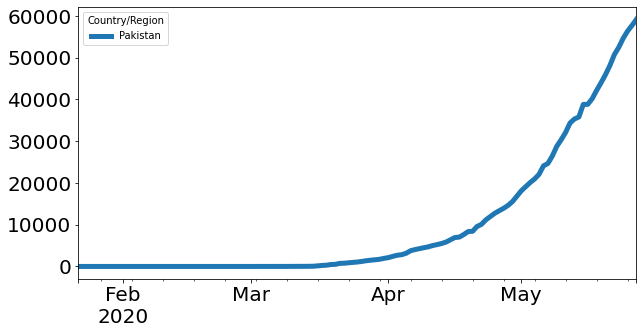

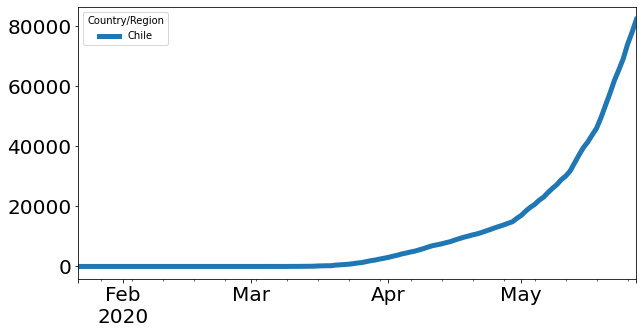

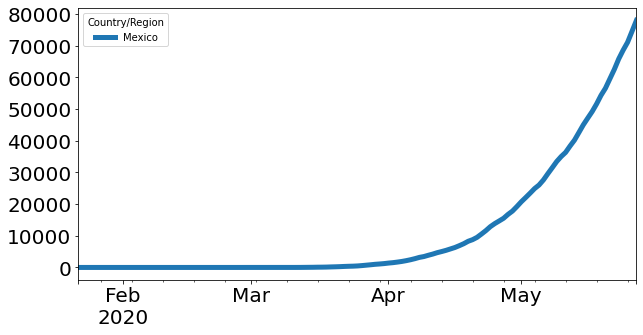

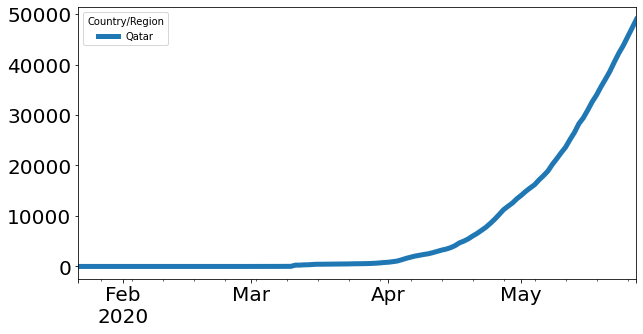

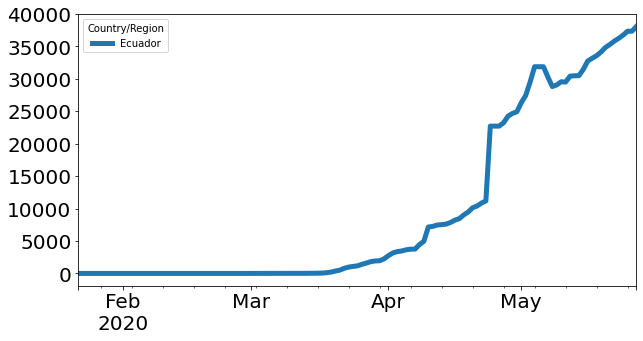

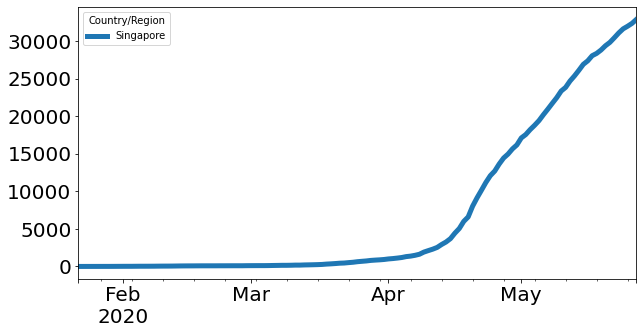

In [152]:
dft[['Pakistan']].plot(figsize=(10,5), linewidth=5, fontsize=20)
dft[['Chile']].plot(figsize=(10,5), linewidth=5, fontsize=20)
dft[['Mexico']].plot(figsize=(10,5), linewidth=5, fontsize=20)
dft[['Qatar']].plot(figsize=(10,5), linewidth=5, fontsize=20)
dft[['Ecuador']].plot(figsize=(10,5), linewidth=5, fontsize=20)
dft[['Singapore']].plot(figsize=(10,5), linewidth=5, fontsize=20)

Making seperate dataframes for each country and converting them into number of new cases in each country everyday (instead of cumulative cases):

In [0]:
pak = dft[['Pakistan']].copy()
chi = dft[['Chile']].copy()
mex = dft[['Mexico']].copy()
qat = dft[['Qatar']].copy()
ecu = dft[['Ecuador']].copy()
sin = dft[['Singapore']].copy()

pak = pak.diff().fillna(0).astype(np.int64)
chi = chi.diff().fillna(0).astype(np.int64)
mex = mex.diff().fillna(0).astype(np.int64)
qat = qat.diff().fillna(0).astype(np.int64)
ecu = ecu.diff().fillna(0).astype(np.int64)
sin = sin.diff().fillna(0).astype(np.int64)

## Preprocessing

Train-test split:
May 10th to May 27th is used for testing, the rest of the dataset is used for training the model

In [0]:
test_size = 23

pak_train = pak[:-test_size]
pak_test = pak[-test_size:]

chi_train = chi[:-test_size]
chi_test = chi[-test_size:]

mex_train = mex[:-test_size]
mex_test = mex[-test_size:]

qat_train = qat[:-test_size]
qat_test = qat[-test_size:]

ecu_train = ecu[:-test_size]
ecu_test = ecu[-test_size:]

sin_train = sin[:-test_size]
sin_test = sin[-test_size:]

In [155]:
pak_train

Country/Region,Pakistan
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-04-30,1292
2020-05-01,1297
2020-05-02,989
2020-05-03,981


Scaling the data between 0 and 1 for faster training using a minmax scaler

In [0]:
def scale(train, test):
  scaler = MinMaxScaler(feature_range=(0,1))

  scaler = scaler.fit(train)
  train = scaler.transform(train)
  test = scaler.transform(test)

  return train, test

In [0]:
pak_train, pak_test = scale(pak_train, pak_test)
chi_train, chi_test = scale(chi_train, chi_test)
mex_train, mex_test = scale(mex_train, mex_test)
qat_train, qat_test = scale(qat_train, qat_test)
ecu_train, ecu_test = scale(ecu_train, ecu_test)
sin_train, sin_test = scale(sin_train, sin_test)

In [0]:
def sequence(data, length):
  x = []
  y = []

  for i in range(len(data) - length - 1):
    a = data[i: (i + length)]
    b = data[i + length]
    x.append(a)
    y.append(b)

  x = np.array(x)
  y = np.array(y)

  return x, y

In [0]:
def train_test(train, test, length):

  X_train, y_train = sequence(train, length)
  X_test, y_test = sequence(test, length)

  X_train = torch.from_numpy(X_train).float()
  y_train = torch.from_numpy(y_train).float()
  X_test = torch.from_numpy(X_test).float()
  y_test = torch.from_numpy(y_test).float()
  
  return X_train, y_train, X_test, y_test

In [0]:
pak_X_train, pak_y_train, pak_X_test, pak_y_test = train_test(pak_train, pak_test, 5)
chi_X_train, chi_y_train, chi_X_test, chi_y_test = train_test(chi_train, chi_test, 5)
mex_X_train, mex_y_train, mex_X_test, mex_y_test = train_test(mex_train, mex_test, 5)
qat_X_train, qat_y_train, qat_X_test, qat_y_test = train_test(qat_train, qat_test, 5)
ecu_X_train, ecu_y_train, ecu_X_test, ecu_y_test = train_test(ecu_train, ecu_test, 5)
sin_X_train, sin_y_train, sin_X_test, sin_y_test = train_test(sin_train, sin_test, 5)

## LSTM prediction model

In [0]:
class Predictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(Predictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
  
  """#Constructor method
  def __init__(self, input, hidden, seq_length, layers):
    super(Predictor, self).__init__()

    #Properties
    self.input = input
    self.hidden = hidden
    self.seq_length = seq_length
    self.layers = layers

    #Functions
    #LSTM
    self.lstm = nn.LSTM(input_size=input, hidden_size=hidden, num_layers=layers, dropout=0.5)
    #Linear layer
    self.linear = nn.Linear(in_features=hidden, out_features=1)

  #Reset state
  def reset(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_length, self.hidden),
        torch.zeros(self.layers, self.seq_length, self.hidden)
    )

  #Predict y
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
        sequences.view(len(sequences), self.seq_length, -1),
        self.hidden
    )

    last_time_step = lstm_out.view(self.seq_length, len(sequences), self.hidden)[-1]
    y_pred = self.linear(last_time_step)

    return y_pred"""

In [0]:
def trainer(model, X_train, y_train, X_test=None, y_test=None):

  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

  """epochs = 60

  optimizer = optim.Adam(model.parameters(), lr=0.01)
  loss_function = nn.MSELoss(reduction='sum')

  train_hist = np.zeros(epochs)
  test_hist = np.zeros(epochs)

  for i in range(epochs):
    model.reset()
    y_pred = model(train_data)
    loss = loss_function(y_pred.float(), train_labels)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    train_hist[i] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return model.eval(), train_hist, test_hist"""

In [173]:
model = Predictor(1, 512, seq_len=5, n_layers=2)

def modeller(model, X_train, y_train, X_test, y_test):
  model, train_hist, test_hist = trainer(model, X_train, y_train, X_test, y_test)

  return model, train_hist, test_hist
  

pak_model, pak_train_hist, pak_test_hist = modeller(model, pak_X_train, pak_y_train, pak_X_test, pak_y_test)
chi_model, chi_train_hist, chi_test_hist = modeller(model, chi_X_train, chi_y_train, chi_X_test, chi_y_test)
mex_model, mex_train_hist, mex_test_hist = modeller(model, mex_X_train, mex_y_train, mex_X_test, mex_y_test)
qat_model, qat_train_hist, qat_test_hist = modeller(model, qat_X_train, qat_y_train, qat_X_test, qat_y_test)
ecu_model, ecu_train_hist, ecu_test_hist = modeller(model, ecu_X_train, ecu_y_train, ecu_X_test, ecu_y_test)
sin_model, sin_train_hist, sin_test_hist = modeller(model, sin_X_train, sin_y_train, sin_X_test, sin_y_test)

Epoch 0 train loss: 9.298969268798828 test loss: 35.54503631591797
Epoch 10 train loss: 4.989492416381836 test loss: 18.311491012573242
Epoch 20 train loss: 3.5543673038482666 test loss: 94.95613098144531
Epoch 30 train loss: 2.1177897453308105 test loss: 278.2997741699219
Epoch 40 train loss: 1.741258144378662 test loss: 499.17919921875
Epoch 50 train loss: 1.6572275161743164 test loss: 545.8081665039062
Epoch 0 train loss: 2.942269802093506 test loss: 338.52099609375
Epoch 10 train loss: 5.245661735534668 test loss: 44.8617057800293
Epoch 20 train loss: 3.670412063598633 test loss: 56.699275970458984
Epoch 30 train loss: 3.6718387603759766 test loss: 58.12291717529297
Epoch 40 train loss: 3.561347723007202 test loss: 53.17491912841797
Epoch 50 train loss: 3.493460178375244 test loss: 47.0927734375
Epoch 0 train loss: 4.937718391418457 test loss: 20.527786254882812
Epoch 10 train loss: 2.7337546348571777 test loss: 10.204423904418945
Epoch 20 train loss: 1.1999683380126953 test loss: 

Making predictions

In [0]:
def predict(name, model, data, train, X_train, X_test, y_test):

  scaler = MinMaxScaler(feature_range=(0,1))

  scaler = scaler.fit(train)

  with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
      y_test_pred = model(test_seq)
      pred = torch.flatten(y_test_pred).item()
      preds.append(pred)
      new_seq = test_seq.numpy().flatten()
      new_seq = np.append(new_seq, [pred])
      new_seq = new_seq[1:]
      test_seq = torch.as_tensor(new_seq).view(1, 5, 1).float()

  
  true_cases = scaler.inverse_transform(
      np.expand_dims(y_test.flatten().numpy(), axis=0)
  ).flatten()

  predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
  ).flatten()

  
  plt.plot(
    data.index[:len(train)], 
    scaler.inverse_transform(train).flatten(),
    label='Precious Cases'
  )

  plt.plot(
    data.index[len(train):len(train) + len(true_cases)], 
    true_cases,
    label='Real Cases'
  )

  plt.plot(
    data.index[len(train):len(train) + len(true_cases)], 
    predicted_cases, 
    label='Predicted Cases'
  )

  plt.title(name)
  plt.legend()
  plt.figure(num=None, figsize=(20,10))

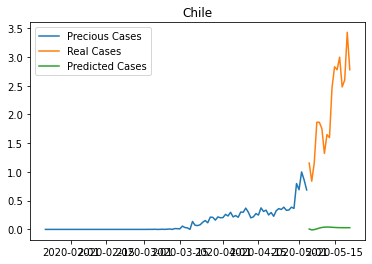

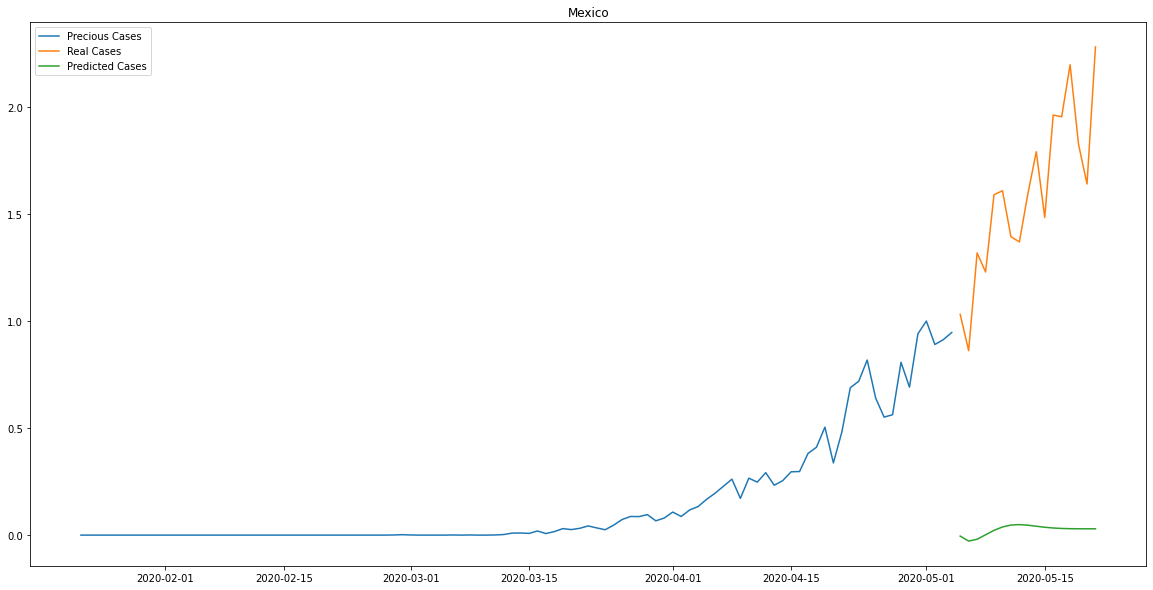

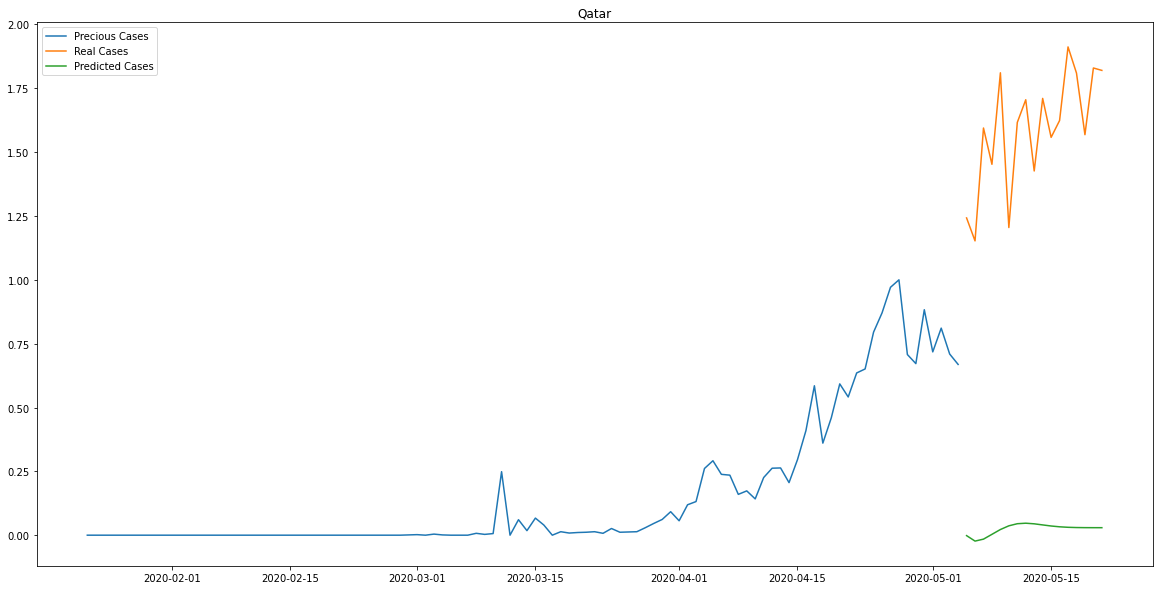

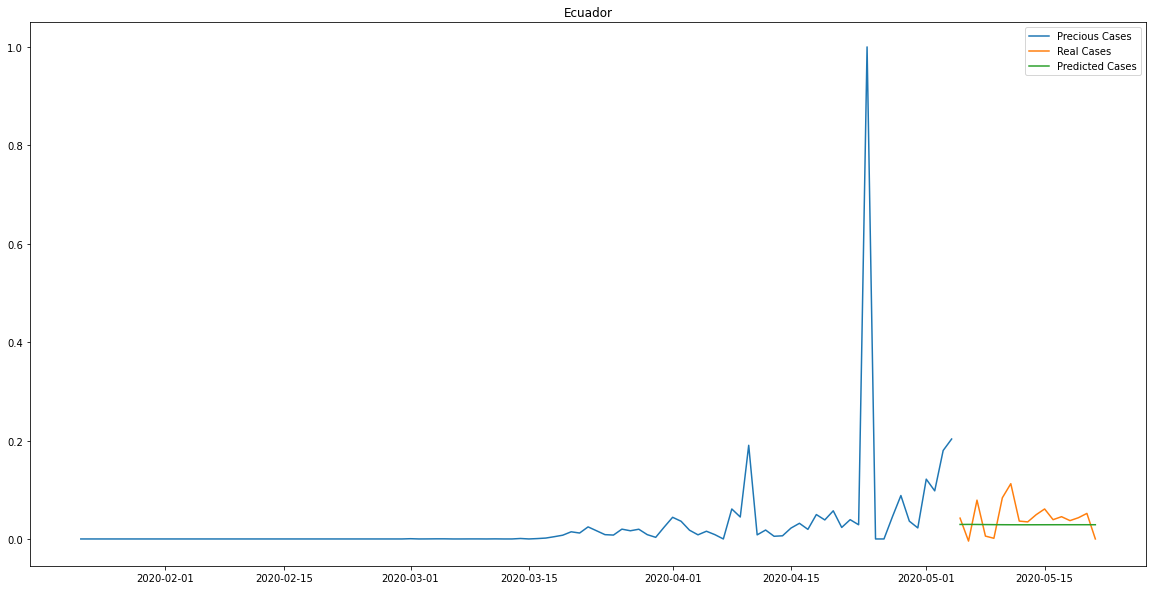

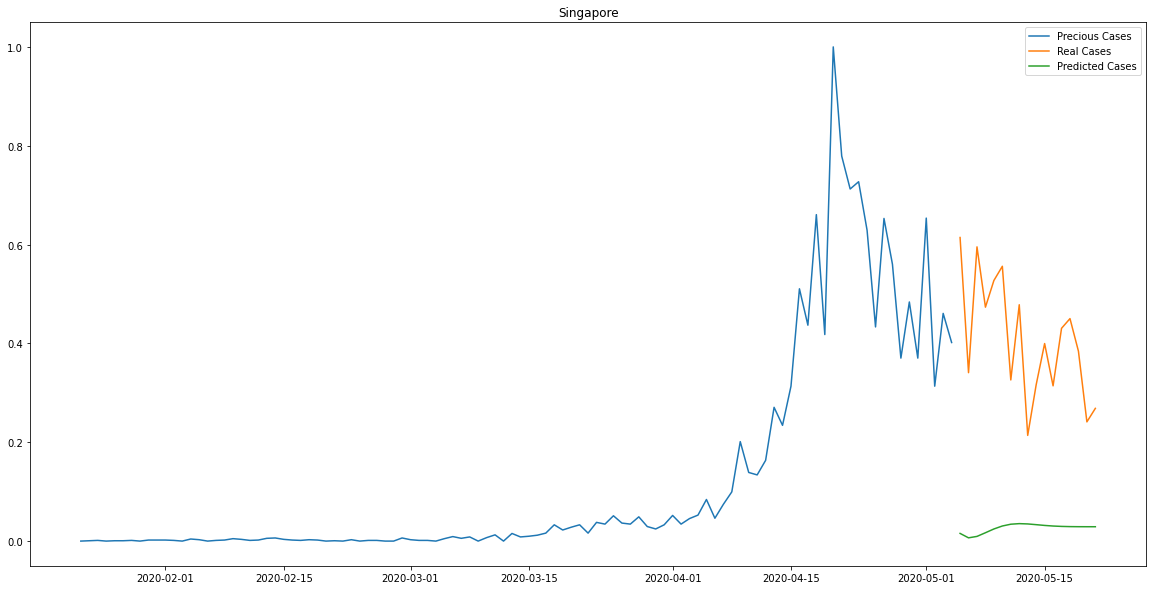

<Figure size 1440x720 with 0 Axes>

In [201]:
predict("Chile", chi_model, chi, chi_train, chi_X_train, chi_X_test, chi_y_test)
predict("Mexico", mex_model, mex, mex_train, mex_X_train, mex_X_test, mex_y_test)
predict("Qatar", qat_model, qat, qat_train, qat_X_train, qat_X_test, qat_y_test)
predict("Ecuador", ecu_model, ecu, ecu_train, ecu_X_train, ecu_X_test, ecu_y_test)
predict("Singapore", sin_model, sin, sin_train, sin_X_train, sin_X_test, sin_y_test)

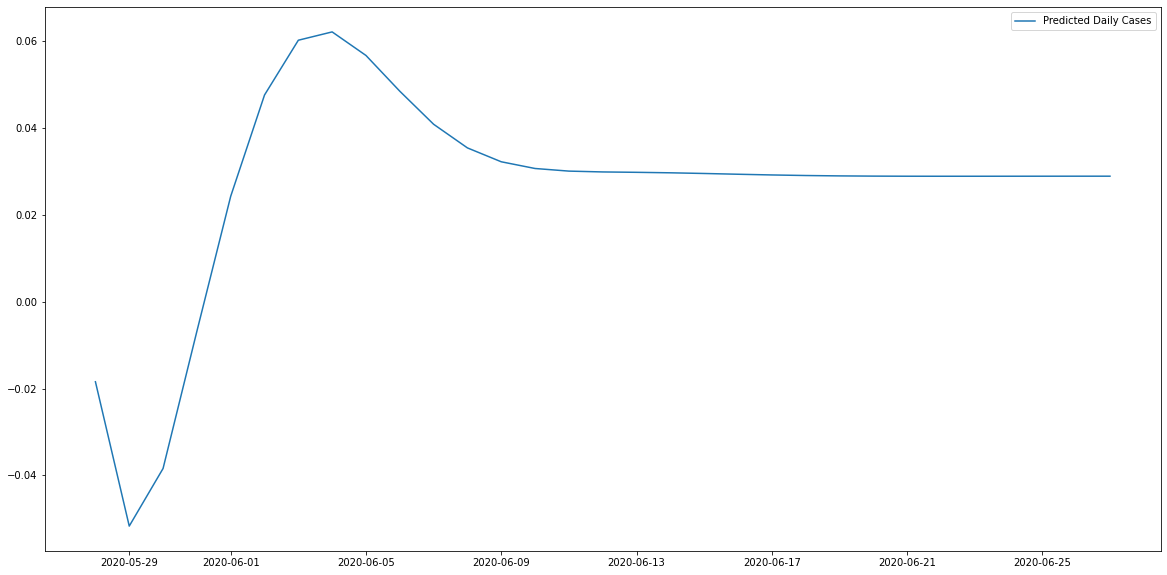

In [207]:
DAYS_TO_PREDICT = 31

scaler = MinMaxScaler(feature_range=(0,1))

scaler = scaler.fit(pak_train)

with torch.no_grad():
  test_seq = pak_X_test[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, 5, 1).float()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

predicted_index = pd.date_range(
  start = pak.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data = predicted_cases,
  index = predicted_index
)

plt.figure(num=None, figsize=(20,10))
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()